In [121]:
# import libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import contractions
from unidecode import unidecode
import pandas as pd
import re
import os
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from autocorrect import Speller

## 1. ●	Data Exploration and Preparation

In [ ]:
# create the dataframe

In [122]:
negative_folder = r"C:\Users\mohni\Downloads\New Dataset\Dataset\Negative" # Negative path on local
positive_folder = r"C:\Users\mohni\Downloads\New Dataset\Dataset\Positive"  # Positive Path on local

In [20]:
negative_files = os.listdir(negative_folder)  # List all the files in each folder
positive_files = os.listdir(positive_folder)  
print(len(negative_files))
print(len(positive_files))

21461
21466


In [16]:
reviews = []
labels = []
folder_paths = [negative_folder, positive_folder]
for folder_path, label in zip(folder_paths, [0, 1]):
    files = os.listdir(folder_path)
    for file in files:
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:   # Read each of the text files
            review = f.read()
            reviews.append(review)
            labels.append(label)

In [17]:
df = pd.DataFrame({'Review': reviews, 'Label': labels})  # Create Dataframe which have columns Review and Label
df

,Review,Label
0,Once again Mr. Costner has dragged out a movie...,0
1,Story of a man who has unnatural feelings for ...,0
2,Airport '77 starts as a brand new luxury 747 p...,0
3,"First of all I hate those moronic rappers, who...",0
4,This film lacked something I couldn't put my f...,0
...,...,...
42922,I am amazed at how this movie(and most others ...,1
42923,"From the start of ""The Edge Of Love"", the view...",1
42924,"This movie, with all its complexity and subtle...",1
42925,A Christmas Together actually came before my t...,1


In [18]:
new_df = df.sample(frac=1).reset_index(drop=True)  # shuffle the dataset to randomize 
new_df

,Review,Label
0,I don't think that many films (especially come...,1
1,BLACK WATER has to be one of the best Australi...,1
2,The only thing good about this movie is the ar...,0
3,"If you live in the suburbs, are relatively wel...",0
4,"Another ""must have"" film. Henry Brandon is a f...",1
...,...,...
42922,I am not a golf fan by any means. On May 26 ab...,1
42923,Claire Denis's Chocolat is a beautiful but fru...,1
42924,"Chilly, alienating adaptation of Rebecca West'...",0
42925,I saw this documentary film at the 2005 Slamda...,1


In [19]:
new_df.to_csv('movie_reviews_dataset.csv', index=False)      # Create CSV file 

In [21]:
len(positive_files)+len(negative_files)

42927

## 2.●	Data Gathering 

In [46]:
df = pd.read_csv("movie_reviews_dataset.csv") # load the CSV file By using pandas library
df

,Review,Label
0,I don't think that many films (especially come...,1
1,BLACK WATER has to be one of the best Australi...,1
2,The only thing good about this movie is the ar...,0
3,"If you live in the suburbs, are relatively wel...",0
4,"Another ""must have"" film. Henry Brandon is a f...",1
...,...,...
42922,I am not a golf fan by any means. On May 26 ab...,1
42923,Claire Denis's Chocolat is a beautiful but fru...,1
42924,"Chilly, alienating adaptation of Rebecca West'...",0
42925,I saw this documentary film at the 2005 Slamda...,1


In [47]:
df["Review"][0]

'I don\'t think that many films (especially comedies) have added memorable, quotable dialog like MOONSTRUCK. I won\'t illustrate it - you can see a remarkably long list of quotes on this thread - but any film that can make subjects like the defense of using expensive copper piping rather than brass for plumbing purposes into memorable dialog is amazing to me. It is not the only line that pops up and makes an imprint on our memory. How about a restaurant waiter who regrets a planned marriage proposal because it will mean the loss of an old bachelor client? Or a nice, elderly dog fancier encouraging his pack to howl at he moon? Or Perry (John Mahoney\'s) description of a female student\'s youthful promise as "moonlight in a martini" (my favorite line).<br /><br />MOONSTRUCK is a wonderful example of brilliant script, first rate direction, and a good ensemble cast that fits perfectly. There are other examples (the drama THE OX-BOW INCIDENT is another example, but a grimmer one). Cher, Oly

In [48]:
df["Label"]

0        1
1        1
2        0
3        0
4        1
        ..
42922    1
42923    1
42924    0
42925    1
42926    0
Name: Label, Length: 42927, dtype: int64

## 3.●	Data Preprocessing 

In [49]:
# Explore the dataset
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42927 entries, 0 to 42926
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  42927 non-null  object
 1   Label   42927 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 670.9+ KB


,Review,Label
0,I don't think that many films (especially come...,1
1,BLACK WATER has to be one of the best Australi...,1
2,The only thing good about this movie is the ar...,0
3,"If you live in the suburbs, are relatively wel...",0
4,"Another ""must have"" film. Henry Brandon is a f...",1
5,This is truly terrible: painfully irritating s...,0
6,If you are looking for a movie with beautiful ...,0
7,This movie is so bad it's good -- in an uninte...,0
8,A fabulous book about a fox and his family who...,0
9,'Deliverance' is a brilliant condensed epic of...,1


In [50]:
# Divide the data independent and dependent
X = df['Review']
Y = df["Label"]

#### Text cleaning

In [51]:
# remove spaces,newlines
def remove_spaces(df):
    clean_text = re.sub("[^a-zA-Z]"," ",df)
    clean_text = df.replace("\\"," ").replace("\n"," ")
    return clean_text

# contraction mapping
def expand_text(df):
    expanded_text = contractions.fix(df)
    return expanded_text

# handling accented characters
def handling_accented(df):
    fixed_text = unidecode(df)
    return fixed_text

# Cleaning
stopword_list = stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('nor')
stopword_list.remove('not')

def clean_data(df):
    tokens = word_tokenize(df)
    clean_text = [word.lower() for word in tokens if (word not in punctuation) and (word.lower() not in stopword_list) and (len(word)>2) and (word.isalpha())]
    return clean_text

# autocorrection
def autocorrection(df):
    spell = Speller(lang='en')
    corrected_text = spell(df)
    return corrected_text

# lemmatization
def lemmatization(df):
    lemmatizer = WordNetLemmatizer()
    final_data = []
    for word in df:
        lemmatized_word = lemmatizer.lemmatize(word)
        final_data.append(lemmatized_word)
    return ' '.join(final_data)


In [52]:
df["Review"]

0        I don't think that many films (especially come...
1        BLACK WATER has to be one of the best Australi...
2        The only thing good about this movie is the ar...
3        If you live in the suburbs, are relatively wel...
4        Another "must have" film. Henry Brandon is a f...
                               ...                        
42922    I am not a golf fan by any means. On May 26 ab...
42923    Claire Denis's Chocolat is a beautiful but fru...
42924    Chilly, alienating adaptation of Rebecca West'...
42925    I saw this documentary film at the 2005 Slamda...
42926    This is a road movie. At least the movie is in...
Name: Review, Length: 42927, dtype: object

In [53]:
clean_text = df["Review"].apply(remove_spaces)

clean_text = clean_text.apply(expand_text)

clean_text = clean_text.apply(handling_accented)

clean_text = clean_text.apply(clean_data)

clean_text = clean_text.apply(lemmatization)


In [62]:
clean_text     # finally we got a clean data

0        not think many film especially comedy added me...
1        black water one best australian movie seen man...
2        thing good movie artwork promotion poster geig...
3        live suburb relatively well financially not re...
4        another must film henry brandon favorite surpr...
                               ...                        
42922    not golf fan mean may movie started scene late...
42923    claire denis chocolat beautiful frustrating fi...
42924    chilly alienating adaptation rebecca west book...
42925    saw documentary film slamdance independent fil...
42926    road movie least movie yellow anf think sugges...
Name: Review, Length: 42927, dtype: object

#### count vectorizer

In [124]:
# now i have to convert that text data to the vectorisation format is called as word embedding
# in word enbedding we go with Frequency based, CountVectorizer and TFIDF
# we have also many other techniques like prediction based , Word2vec,fasttext and doc2vec

In [63]:
count_CV = CountVectorizer(max_df=0.95,max_features=1000,lowercase=True)
X_CV = count_CV.fit_transform(clean_text)

In [64]:
X_CV

<42927x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2327489 stored elements in Compressed Sparse Row format>

In [65]:
X_CV.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [66]:
count_CV.get_feature_names_out()

array(['ability', 'able', 'absolutely', 'accent', 'across', 'act',
       'acted', 'acting', 'action', 'actor', 'actress', 'actual',
       'actually', 'adaptation', 'add', 'admit', 'adult', 'adventure',
       'age', 'agent', 'ago', 'agree', 'air', 'alien', 'alive', 'almost',
       'alone', 'along', 'already', 'also', 'although', 'always',
       'amazing', 'america', 'american', 'among', 'amount', 'amusing',
       'animal', 'animation', 'annoying', 'another', 'answer', 'anyone',
       'anything', 'anyway', 'apart', 'apparently', 'appear',
       'appearance', 'appears', 'appreciate', 'around', 'art', 'aside',
       'ask', 'aspect', 'atmosphere', 'attack', 'attempt', 'attention',
       'audience', 'average', 'avoid', 'award', 'away', 'awful', 'baby',
       'back', 'background', 'bad', 'badly', 'band', 'barely', 'based',
       'basic', 'basically', 'battle', 'beautiful', 'beauty', 'became',
       'become', 'becomes', 'bed', 'begin', 'beginning', 'behind',
       'belief', 'beli

In [67]:
pd.DataFrame(X_CV.A,columns=count_CV.get_feature_names_out())

,ability,able,absolutely,accent,across,act,acted,acting,action,actor,...,wrong,wrote,yeah,year,yes,yet,york,young,younger,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
42923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
42924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


#### TFIDF Vectorizer

In [70]:
count_tfidf = TfidfVectorizer(max_df=0.95,max_features=1000)
X_tfidf = count_tfidf.fit_transform(clean_text)

In [71]:
X_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
count_tfidf.get_feature_names_out()

array(['ability', 'able', 'absolutely', 'accent', 'across', 'act',
       'acted', 'acting', 'action', 'actor', 'actress', 'actual',
       'actually', 'adaptation', 'add', 'admit', 'adult', 'adventure',
       'age', 'agent', 'ago', 'agree', 'air', 'alien', 'alive', 'almost',
       'alone', 'along', 'already', 'also', 'although', 'always',
       'amazing', 'america', 'american', 'among', 'amount', 'amusing',
       'animal', 'animation', 'annoying', 'another', 'answer', 'anyone',
       'anything', 'anyway', 'apart', 'apparently', 'appear',
       'appearance', 'appears', 'appreciate', 'around', 'art', 'aside',
       'ask', 'aspect', 'atmosphere', 'attack', 'attempt', 'attention',
       'audience', 'average', 'avoid', 'award', 'away', 'awful', 'baby',
       'back', 'background', 'bad', 'badly', 'band', 'barely', 'based',
       'basic', 'basically', 'battle', 'beautiful', 'beauty', 'became',
       'become', 'becomes', 'bed', 'begin', 'beginning', 'behind',
       'belief', 'beli

In [73]:
pd.DataFrame(tfidf_train.A,columns=count_tfidf.get_feature_names_out())

,ability,able,absolutely,accent,across,act,acted,acting,action,actor,...,wrong,wrote,yeah,year,yes,yet,york,young,younger,zombie
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.050853,0.0,0.064711,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.164101,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.092032,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.129609,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.167761,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.114794,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42922,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.220111,0.0,0.0
42923,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.083907,0.0,0.0
42924,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
42925,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.139189,0.0,0.000000,0.0,0.000000,0.0,0.0


## 4) ●	Model Building

#### Multinomial with CountVectorizer

In [74]:
Y

0        1
1        1
2        0
3        0
4        1
        ..
42922    1
42923    1
42924    0
42925    1
42926    0
Name: Label, Length: 42927, dtype: int64

#### Multinomial With CountVectoriser

In [76]:
# Split the data in training and testing subsets For CountVectoriser
x_train_CV, x_test_CV, y_train_CV, y_test_CV = train_test_split(X_CV,Y,test_size=0.2,random_state=42)
mnb_model = MultinomialNB()
mnb_model.fit(x_train_CV,y_train_CV)

MultinomialNB()

## 5.1)●	Model Evaluation For CV

In [78]:
def evaluation(string, model, ind_var, act):
    print(string.center(50,'*'))
    pred = model.predict(ind_var)
    cnf_matrix = confusion_matrix(act,pred)
    print('Confusion Matrix :\n', cnf_matrix)
    
    accuracy = accuracy_score(act,pred)
    print('Accuracy :', accuracy)
    
    clf_report = classification_report(act, pred)
    print('Classification Report :\n', clf_report)

In [81]:
print('MultinomialNB Model With CountVectorizer Results'.center(80,'*'))
evaluation('Train Data Evaluation', mnb_model, x_train_CV, y_train_CV)
print('*#'*30)
evaluation('Test Data Evaluation', mnb_model, x_test_CV, y_test_CV)

****************MultinomialNB Model With CountVectorizer Results****************
**************Train Data Evaluation***************
Confusion Matrix :
 [[14190  2993]
 [ 2719 14439]]
Accuracy : 0.8336682100113567
Classification Report :
               precision    recall  f1-score   support

           0       0.84      0.83      0.83     17183
           1       0.83      0.84      0.83     17158

    accuracy                           0.83     34341
   macro avg       0.83      0.83      0.83     34341
weighted avg       0.83      0.83      0.83     34341

*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
***************Test Data Evaluation***************
Confusion Matrix :
 [[3520  758]
 [ 730 3578]]
Accuracy : 0.8266946191474493
Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      4278
           1       0.83      0.83      0.83      4308

    accuracy                           0.83      8586
   

#### Multinomial With TFIDF

#### TFIDF Vectorizer

In [86]:
tfidf = TfidfVectorizer(max_df=0.95,max_features=1000)
tfidf_train = tfidf.fit_transform(clean_text_train)
tfidf_test = tfidf.transform(clean_text_test)

In [87]:
tfidf.get_feature_names_out()

array(['ability', 'able', 'absolutely', 'accent', 'across', 'act',
       'acted', 'acting', 'action', 'actor', 'actress', 'actual',
       'actually', 'adaptation', 'add', 'admit', 'adult', 'adventure',
       'age', 'ago', 'agree', 'air', 'alien', 'alive', 'almost', 'alone',
       'along', 'already', 'also', 'although', 'always', 'amazing',
       'america', 'american', 'among', 'amount', 'amusing', 'animal',
       'animation', 'annoying', 'another', 'answer', 'anyone', 'anything',
       'anyway', 'apart', 'apparently', 'appear', 'appearance', 'appears',
       'appreciate', 'around', 'art', 'aside', 'ask', 'aspect',
       'atmosphere', 'attack', 'attempt', 'attention', 'audience',
       'average', 'avoid', 'award', 'away', 'awful', 'baby', 'back',
       'background', 'bad', 'badly', 'band', 'barely', 'based', 'basic',
       'basically', 'battle', 'beautiful', 'beauty', 'became', 'become',
       'becomes', 'begin', 'beginning', 'behind', 'belief', 'believable',
       'believ

In [88]:
pd.DataFrame(tfidf_train.A,columns=tfidf.get_feature_names_out())

,ability,able,absolutely,accent,across,act,acted,acting,action,actor,...,wrong,wrote,yeah,year,yes,yet,york,young,younger,zombie
0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.137273,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.116272,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.000000,0.136065,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.087293,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.116668,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.065555,0.0,0.000000,0.0,0.079313,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32190,0.000000,0.000000,0.000000,0.0,0.0,0.06563,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.044989,0.0,0.000000,0.0,0.000000,0.0,0.0
32191,0.111043,0.000000,0.089488,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
32192,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
32193,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.131519,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [90]:
# Split the data in training and testing subsets for TFIDF
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,Y,test_size=0.2,random_state=42)
mnb_model_tfidf = MultinomialNB()
mnb_model_tfidf.fit(x_train_tfidf,y_train_tfidf)

MultinomialNB()

## 5.1)●	Model Evaluation For TFIDF

In [91]:
print('MultinomialNB With TFIDF Model Results'.center(80,'*'))
evaluation('Train Data Evaluation', mnb_model, x_train_tfidf, y_train_tfidf)
print('*#'*30)
evaluation('Test Data Evaluation', mnb_model, x_test_tfidf, y_test_tfidf)

*********************MultinomialNB With TFIDF Model Results*********************
**************Train Data Evaluation***************
Confusion Matrix :
 [[13620  3563]
 [ 2208 14950]]
Accuracy : 0.8319501470545412
Classification Report :
               precision    recall  f1-score   support

           0       0.86      0.79      0.83     17183
           1       0.81      0.87      0.84     17158

    accuracy                           0.83     34341
   macro avg       0.83      0.83      0.83     34341
weighted avg       0.83      0.83      0.83     34341

*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
***************Test Data Evaluation***************
Confusion Matrix :
 [[3374  904]
 [ 607 3701]]
Accuracy : 0.8240158397391102
Classification Report :
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      4278
           1       0.80      0.86      0.83      4308

    accuracy                           0.82      8586
   

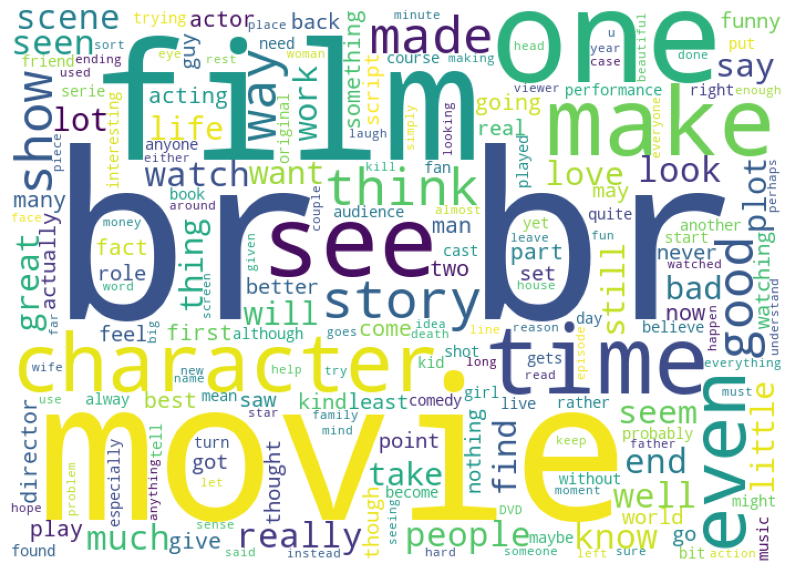

In [88]:
def wordcloud(data,column):
    df_ = data[column].str.cat(sep=' ')
    wordcloud = WordCloud(width=700,height=500,background_color = 'white').generate(df_)
    plt.figure(figsize=(10,16))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

wordcloud(df,"Review")


### Save the model

In [ ]:
#  finally we save our model for the prediction purpose

In [109]:
with open('tfidf_Vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [110]:
# save the TFIDF model
with open('TFIDF1.pkl', 'wb') as file:
    pickle.dump(mnb_model_tfidf, file)

## 6) ●	Inference on New Data

#### Load the Model For Prediction on Practically

In [111]:
with open('tfidf_Vectorizer.pkl', 'rb') as file:
    cv_model = pickle.load(file)

In [112]:
with open('TFIDF1.pkl', 'rb') as file:
    load_model = pickle.load(file)

In [118]:
# create the def function for the testing purpose
def Prediction(review):
    data = cv_model.transform([review]).toarray()
    result = loaded_model.predict(data)[0]
    if result == 1:
        return "Positive Review"
    else:
        return "Negative Review"

In [119]:
review = "this is a wonderful movie of my life"
test = Prediction(review)
test

'Positive Review'

In [120]:
review = "this is the worst movie i have ever seen"
test = Prediction(review)
test

'Negative Review'

####  For text classification we have different types of techniques :- 
#### Use supervised learning algorithms such as Naive Bayes, Support Vector Machines, or deep learning models like LSTM or   BERT to classify text into positive, negative, or neutral sentiment.
